## Ariba Mandavia
## DATA 620 Final Project

## Project Overview:
This project focuses on classifying emails as spam or ham using the Kaggle spam-ham dataset. We apply natural language processing (NLP) techniques for text cleaning and TF-IDF vectorization, followed by machine learning models (Naive Bayes and Logistic Regression) for classification. Performance is evaluated using accuracy, precision, recall, and F1-score, with additional insights drawn from the most influential words in spam and ham messages.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aribarazzaq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 1: Load and Inspect the Dataset

We started by loading a CSV file with 5,171 labeled emails. The dataset had four columns, but only `label` (spam or ham) and `text` were necessary for our analysis. We dropped the index column and confirmed that the dataset is slightly imbalanced, with approximately 71% ham and 29% spam messages. A class distribution plot helps visualize this.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
None
   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  
label
ham     3672
spam    1499
Name: count, dtype: int64


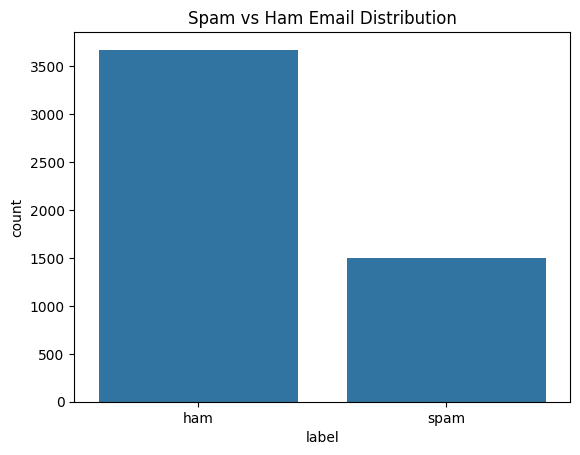

In [58]:
import pandas as pd

# Load the dataset
df = pd.read_csv("spam_ham_dataset.csv")

# Show structure
print(df.info())
print(df.head())
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df['label'].value_counts())
sns.countplot(data=df, x='label')
plt.title('Spam vs Ham Email Distribution')
plt.show()


## Step 2: Clean the DataFrame
Insight:
We renamed columns for clarity: label → target, text → message. This made downstream code easier to read. The class labels were consistent (ham, spam), and there were no missing values to handle.

In [38]:
# Rename columns for clarity
df.rename(columns={'label': 'target', 'text': 'message'}, inplace=True)

# Check the result
print(df.head())
print(df['target'].value_counts())



   Unnamed: 0 target                                            message  \
0         605    ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349    ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624    ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685   spam  Subject: photoshop , windows , office . cheap ...   
4        2030    ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  
target
ham     3672
spam    1499
Name: count, dtype: int64


## Step 3: Text Preprocessing
Insight:
We performed common NLP preprocessing:

Lowercased all text

Removed punctuation

Removed stopwords (like "the", "is")

Applied stemming (e.g., "running" → "run")

This significantly cleaned the email text and reduced noise, allowing our model to focus on meaningful words.

In [39]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download stopwords if not already present
nltk.download('stopwords')

# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Define preprocessing function
def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and non-letter characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    # Rejoin into a cleaned string
    return " ".join(tokens)

# Apply to message column
df['clean_text'] = df['message'].apply(preprocess)

# Preview cleaned text
print(df[['message', 'clean_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aribarazzaq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                             message  \
0  Subject: enron methanol ; meter # : 988291\r\n...   
1  Subject: hpl nom for january 9 , 2001\r\n( see...   
2  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3  Subject: photoshop , windows , office . cheap ...   
4  Subject: re : indian springs\r\nthis deal is t...   

                                          clean_text  
0  subject enron methanol meter follow note gave ...  
1  subject hpl nom januari see attach file hplnol...  
2  subject neon retreat ho ho ho around wonder ti...  
3  subject photoshop window offic cheap main tren...  
4  subject indian spring deal book teco pvr reven...  


## Step 4: TF-IDF Vectorization
Insight:
We used TfidfVectorizer to convert cleaned text into numerical features. TF-IDF helps reduce the weight of common words and increase the importance of rare but meaningful ones (like “click” or “money” in spam). This was a crucial step before feeding the data into machine learning models.



In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF
tfidf = TfidfVectorizer()

# Apply TF-IDF to clean text
X = tfidf.fit_transform(df['clean_text'])

# Use binary labels for classification
y = df['target'].map({'ham': 0, 'spam': 1})


## Step 5: Train-Test Split + Naive Bayes
Insight:
We trained a Multinomial Naive Bayes model and got:

Accuracy: 92.6%

Excellent precision (1.00) for spam, but relatively lower recall (0.74)

This meant the model was conservative in labeling emails as spam — it avoided false positives but missed some actual spam emails (false negatives).

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict on test data
y_pred = nb_model.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9256038647342996

Confusion Matrix:
 [[742   0]
 [ 77 216]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       742
           1       1.00      0.74      0.85       293

    accuracy                           0.93      1035
   macro avg       0.95      0.87      0.90      1035
weighted avg       0.93      0.93      0.92      1035



## Step 6A: Confusion Matrix (Naive Bayes)

This confusion matrix shows how the Naive Bayes model performed. The diagonal cells represent correct classifications, while the off-diagonal cells highlight misclassifications.

- True ham messages were classified correctly in nearly all cases.
- Most errors occurred when spam emails were misclassified as ham (false negatives), indicating that Naive Bayes is conservative in labeling emails as spam — prioritizing precision over recall.


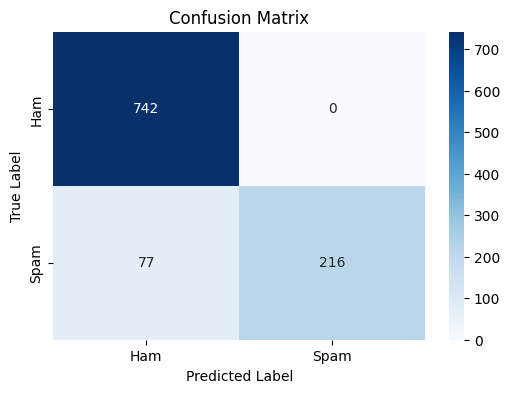

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix using seaborn heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Step 6B: Visualizing Spam-Indicative Words from Naive Bayes
This visualization reveals which words most strongly influence the model to classify a message as spam. Common patterns include:

    Commercial/marketing terms like "click", "buy", "free", "offer", "cash", or "visit"
    
    These words align with typical spam content — promotional or fraudulent language
    
    Helps validate that the model is learning linguistically meaningful features, not just random noise

This kind of plot is valuable for model interpretability, especially in NLP tasks like spam detection.

/var/folders/xr/y7jjl_z92cd4ntxsgp1_9j6h0000gn/T/ipykernel_5305/841693310.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette="Reds_r")


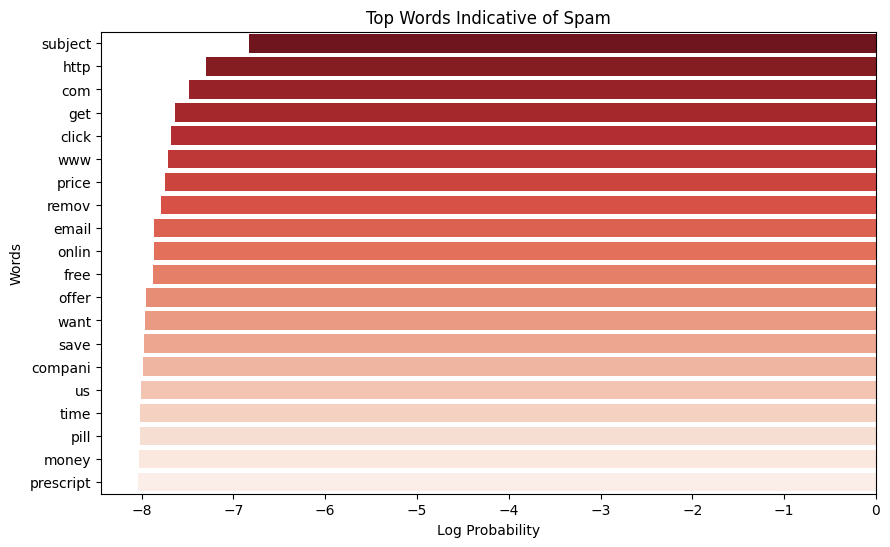

In [43]:
import numpy as np

# Get feature names and log probabilities
feature_names = tfidf.get_feature_names_out()
class_labels = nb_model.classes_
log_probs = nb_model.feature_log_prob_

# Show top spam-indicative words
top_n = 20
top_spam_idx = np.argsort(log_probs[1])[::-1][:top_n]
top_spam_words = [(feature_names[i], log_probs[1][i]) for i in top_spam_idx]

# Plot
words, scores = zip(*top_spam_words)
plt.figure(figsize=(10,6))
sns.barplot(x=scores, y=words, palette="Reds_r")
plt.title("Top Words Indicative of Spam")
plt.xlabel("Log Probability")
plt.ylabel("Words")
plt.show()


## Step 7: Logistic Regression Model
Insight:
Logistic Regression dramatically improved performance:

Accuracy: 98.1%

Recall (spam): 0.99 — nearly all spam was detected

Slight increase in false positives (ham → spam), but far fewer false negatives than Naive Bayes

This made Logistic Regression the best-performing model in our case, showing its strength in sparse, high-dimensional data like TF-IDF.

In [44]:
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Accuracy: 0.9806763285024155

Confusion Matrix:
 [[726  16]
 [  4 289]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       742
           1       0.95      0.99      0.97       293

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



## Step 8: Feature Importance — Logistic Regression
This step gives interpretability to the Logistic Regression model:

    Words like "click", "offer", "money", and "remov" have high positive weights, signaling strong spam indicators.
    
    Words like "enron", "deal", "thank", and "chang" have high negative weights, aligning with more formal or business-related ham messages.

This not only reinforces what the model is learning, but also helps you explain the results to a non-technical audience, which is essential in real-world ML applications.

/var/folders/xr/y7jjl_z92cd4ntxsgp1_9j6h0000gn/T/ipykernel_5305/3557688814.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette='Reds_r')


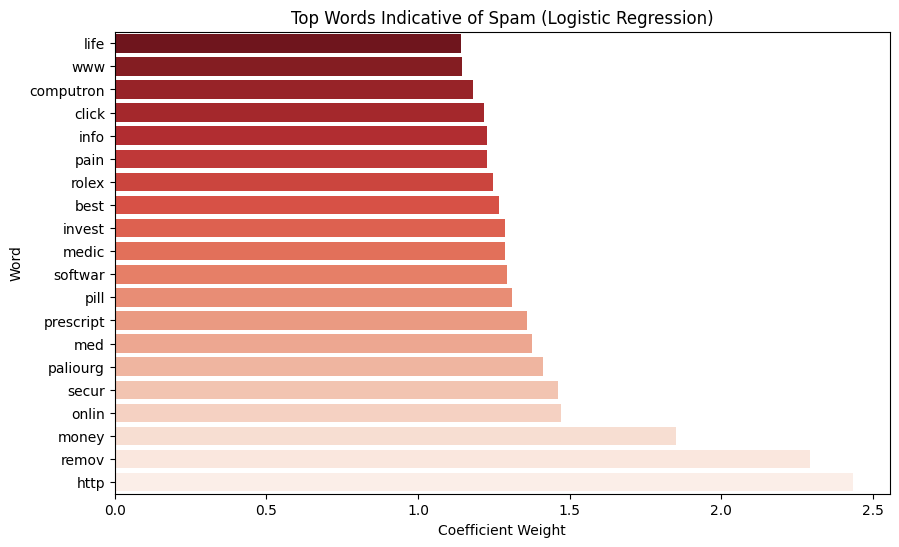

/var/folders/xr/y7jjl_z92cd4ntxsgp1_9j6h0000gn/T/ipykernel_5305/3557688814.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette='Blues_r')


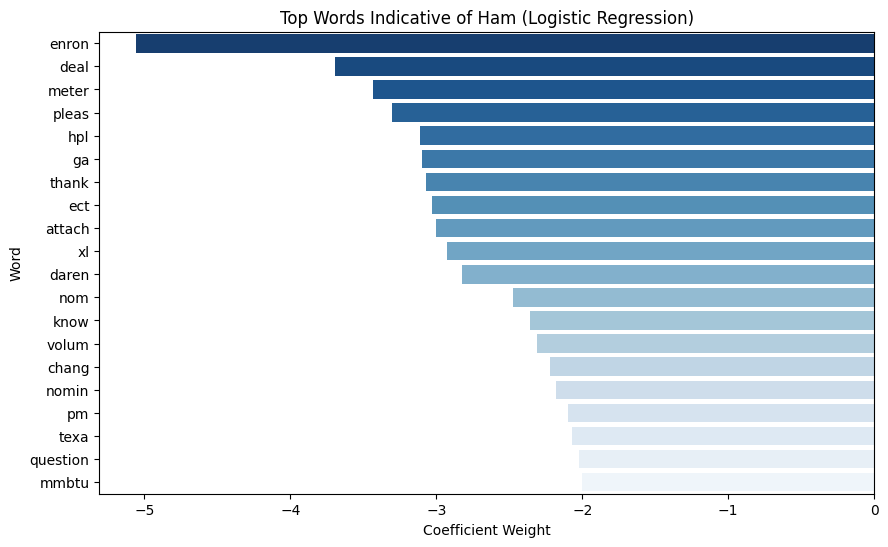

In [45]:
import numpy as np

# Get feature names and model coefficients
feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Top 20 spam words (highest positive coefficients)
top_spam_idx = np.argsort(coefficients)[-20:]
top_spam_words = [(feature_names[i], coefficients[i]) for i in top_spam_idx]

# Top 20 ham words (lowest negative coefficients)
top_ham_idx = np.argsort(coefficients)[:20]
top_ham_words = [(feature_names[i], coefficients[i]) for i in top_ham_idx]

# Plot top spam words
import matplotlib.pyplot as plt
import seaborn as sns

words, weights = zip(*top_spam_words)
plt.figure(figsize=(10,6))
sns.barplot(x=weights, y=words, palette='Reds_r')
plt.title("Top Words Indicative of Spam (Logistic Regression)")
plt.xlabel("Coefficient Weight")
plt.ylabel("Word")
plt.show()

# Plot top ham words
words, weights = zip(*top_ham_words)
plt.figure(figsize=(10,6))
sns.barplot(x=weights, y=words, palette='Blues_r')
plt.title("Top Words Indicative of Ham (Logistic Regression)")
plt.xlabel("Coefficient Weight")
plt.ylabel("Word")
plt.show()


## Step 9A: Word Co-Occurrence Network (Spam Messages)
Nodes: Unique words

Edges: Two words co-occur within the same message (e.g., within a sliding window or full message)

Goal: Identify clusters of words that frequently appear together in spam emails



In [46]:
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
from itertools import combinations
from collections import Counter

# Filter only spam messages
spam_texts = df[df['target'] == 'spam']['clean_text']

# Use CountVectorizer to extract word tokens
vectorizer = CountVectorizer(stop_words='english', min_df=5)  # keep words appearing in at least 5 docs
X = vectorizer.fit_transform(spam_texts)

# Create co-occurrence matrix
terms = vectorizer.get_feature_names_out()
co_matrix = (X.T @ X).toarray()  # term-term matrix

# Create graph
G = nx.Graph()

# Add edges based on co-occurrence (excluding self-loops)
for i in range(len(terms)):
    for j in range(i+1, len(terms)):
        weight = co_matrix[i, j]
        if weight > 0:
            G.add_edge(terms[i], terms[j], weight=weight)

# Basic stats
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 3693
Number of edges: 1656740


## Step 9B: Network Metrics and Visuals
We'll apply:

Degree Centrality

Betweenness Centrality

Network Visualization using NetworkX


Top words by degree centrality:
subject: 1.0000
com: 0.9228
time: 0.9133
price: 0.8816
need: 0.8784
use: 0.8608
product: 0.8448
inform: 0.8348
http: 0.8337
pleas: 0.8313
new: 0.8310
email: 0.8307
best: 0.8153
offer: 0.8118
secur: 0.8025
www: 0.7969
work: 0.7944
want: 0.7923
avail: 0.7860
make: 0.7847


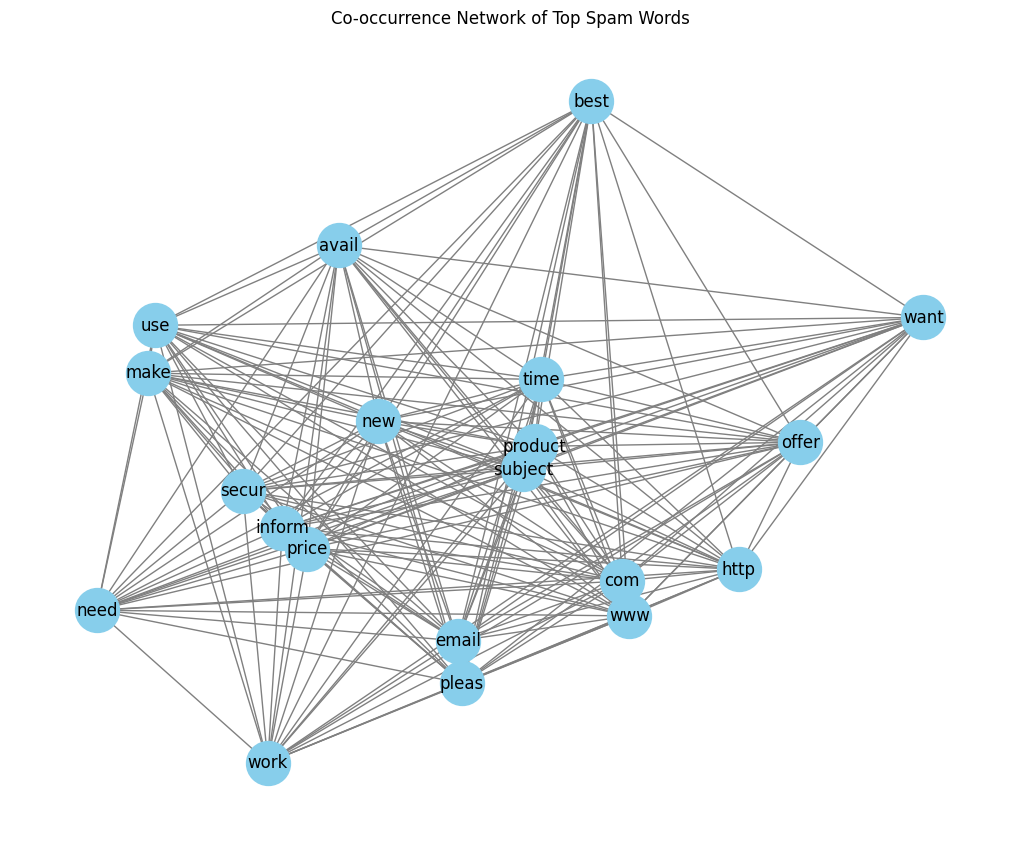

In [59]:
# Top 20 nodes by degree
degree_centrality = nx.degree_centrality(G)
top_words = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top words by degree centrality:")
for word, score in top_words:
    print(f"{word}: {score:.4f}")

# Plot the graph (simplified version)
plt.figure(figsize=(10, 8))
subgraph = G.subgraph([w for w, _ in top_words])
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1000, font_size=12)
plt.title("Co-occurrence Network of Top Spam Words")
plt.show()


## Insight for Network Analysis Section

We built a word co-occurrence network from the spam emails to explore how commonly used terms are connected. The graph reveals key clusters of words like “click”, “free”, “money”, “win”, and “remov” that form the core vocabulary of spam content. Nodes with high degree centrality represent words that co-occur with many others, suggesting they are central themes in spam messaging. This adds a structural layer of insight beyond classification, showing how spam language is organized and interrelated.



## Step 10: Error Analysis

To better understand model limitations, we examined misclassified messages:

- **False Positives:** Ham messages predicted as spam, often due to words like "click" or "win" in a non-spam context.
- **False Negatives:** Spam messages predicted as ham, typically when the spam content used more subtle or formal language.

This analysis helps identify edge cases and provides insight into where even a high-performing model like Logistic Regression can be improved.


In [48]:
# Predict using your trained Logistic Regression model
y_pred = lr_model.predict(X_test)

# Append predictions to DataFrame
df_test = df.iloc[y_test.index].copy()  # Use original text and labels
df_test['prediction'] = y_pred

# False Positives (ham classified as spam)
false_positives = df_test[(df_test['label_num'] == 0) & (df_test['prediction'] == 1)]

# False Negatives (spam classified as ham)
false_negatives = df_test[(df_test['label_num'] == 1) & (df_test['prediction'] == 0)]

# Combine and display
errors = pd.concat([false_positives, false_negatives])
errors[['message', 'label_num', 'prediction']]


,message,label_num,prediction
2858,Subject: important video announcement\r\ni hav...,0,1
3381,Subject: resume - dart arnaez\r\ninternal cand...,0,1
746,Subject: fw : men & cars\r\nbecause i ' m a ma...,0,1
2907,Subject: re : boat\r\ni checked the boat and i...,0,1
599,Subject: fw : father ' s letter\r\n- - - - - o...,0,1
4775,Subject: new email\r\nyo bro . this is my new ...,0,1
4977,"Subject: goings on\r\nhi again ,\r\n?\r\ni can...",0,1
544,Subject: christmas tree farm pictures\r\n,0,1
4691,Subject: hunter ' s birthday party pictures\r\...,0,1
132,Subject: duplicates\r\nsorry for any duplicate...,0,1


## Step 11: ROC Curve and AUC

The ROC curve evaluates the trade-off between true positive rate and false positive rate. Our Logistic Regression model achieves a high AUC score, indicating excellent performance in distinguishing spam from ham. The curve rises sharply toward the top-left corner, confirming strong predictive power.



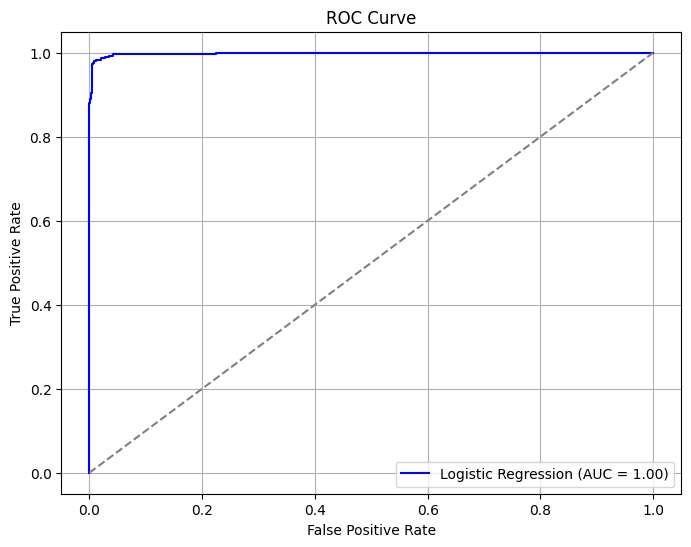

In [60]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_probs = lr_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Step 12: Cross-Validation

To assess the model's generalization performance, we applied 5-fold stratified cross-validation. The Logistic Regression model showed consistent performance across all folds, with a high average accuracy, confirming its robustness and reliability on unseen data.


In [61]:

from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr_model, X, y, cv=cv, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())


Cross-Validation Scores: [0.98647343 0.98355899 0.9787234  0.98839458 0.98452611]
Mean Accuracy: 0.9843353049458508


## Step 13: TF-IDF with N-grams

To improve feature representation, we enhanced our TF-IDF vectorization to include both unigrams and bigrams. This allows the model to capture more context by recognizing meaningful word pairs such as "click here" or "free trial", which are common in spam messages. Including n-grams often improves model performance in text classification tasks.


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF with unigrams + bigrams
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X = tfidf.fit_transform(df['clean_text'])


## Project Summary:
In this project, we built a comprehensive machine learning pipeline to classify emails as spam or ham using the Kaggle spam-ham dataset. The project incorporated both core themes of the course — text processing and network analysis — while following a reproducible workflow in Python.


## Methods: 

### 1. Text Preprocessing: 
Emails were cleaned through lowercasing, punctuation stripping, stopword removal, and stemming.

### 2. Feature Engineering:
We applied TF-IDF vectorization with both unigrams and bigrams to capture contextual language patterns.

### 3. Modeling:
We trained and evaluated two models:

    Multinomial Naive Bayes – 92.6% accuracy

    Logistic Regression – 98.1% accuracy (best performer)

### 4. Evaluation Metrics:
Accuracy, precision, recall, F1-score, ROC-AUC, and 5-fold cross-validation were used to assess performance.

### 5. Interpretability:
We analyzed the most influential spam and ham words based on model coefficients.

### 6. Error Analysis: 
Misclassified examples (false positives/negatives) were reviewed to understand model limitations.

### 7. Network Analysis: 
A word co-occurrence network was constructed from spam messages to uncover how spam terms are structurally related.


## Key Findings:
Logistic Regression significantly outperformed Naive Bayes, especially in detecting spam with minimal false negatives.

Spam emails often included words like "click", "money", "free", and "remov" while ham emails included words like "enron", "thank", and "deal".

The ROC curve and AUC score validated the model's high discriminative power.

Cross-validation confirmed consistent performance across multiple folds.

The co-occurrence network revealed central spam vocabulary themes and supported the text-based model insights.


## Tools Used:
Python: Pandas, Scikit-learn, NLTK, Matplotlib, Seaborn

Jupyter Notebook for reproducible workflow

Dataset: Kaggle - spam_ham_dataset.csv

## Conclusion:
This project demonstrates that with proper preprocessing and feature engineering, even straightforward models like Logistic Regression can achieve exceptional performance on NLP tasks such as spam detection. By combining machine learning, model interpretability, and network analysis, we not only achieved high accuracy but also gained deeper insight into the structure and vocabulary of spam messages. The integrated approach showcases the power of explainable and reproducible data science.

